# Train Interspeech

## Data

In [1]:
balanced = False

In [2]:
preprocessed = False

In [3]:
import pandas as pd

# Cargar el CSV para male
# data = pd.read_csv('data/data_male.csv')
data = pd.read_csv('data/balanced_pseudo_male.csv')

print(len(data))
# Eliminar filas con valores nulos solo en la columna 'text'
data = data.dropna(subset=['text'])
#data.to_csv('data/data_male.csv', index=False)
print(len(data))
data.head()

6384
6384


,FileName,text,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set,PodcastID,StratifyCol,NewPartition,PseudoEmo,InvEntropyNorm,PseudoEmoNum
0,MSP-PODCAST_4583_0017_0001,"from what it looks like, heidi was okay with j...",A,4.8,2.8,5.2,2357,Male,Train,4583,4583_2357_A,Train,A,1.0,2
1,MSP-PODCAST_3162_0475,gave them extra money and then they decided th...,A,6.2,2.6,6.2,2124,Male,Development,3162,3162_2124_A,Train,A,1.0,2
2,MSP-PODCAST_2355_0349,"yes, you're going to fucking die.",A,4.2,2.6,4.8,1601,Male,Train,2355,2355_1601_A,Test,A,1.0,2
3,MSP-PODCAST_5201_1197,and i already kind of had it in my mind,A,5.2,3.6,5.4,2789,Male,Development,5201,5201_2789_A,Train,A,1.0,2
4,MSP-PODCAST_5583_1543,i'm talking about a lot of you guys got to sta...,A,4.8,3.4,4.8,2953,Male,Train,5583,5583_2953_A,Train,A,1.0,2


In [4]:
if balanced:
    # Paso 1: Determinar el tamaño mínimo entre las clases
    min_count = data['PseudoEmo'].value_counts().min()

    # Paso 2: Submuestrear cada clase
    data = data.groupby('PseudoEmo').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

    # Paso 3: Verificar el balance
    print(data['PseudoEmo'].value_counts())
    print(len(data))

    #data.to_csv('data/balanced_pseudo_male.csv', index=False)


In [5]:
# Filtrar los datos en tres conjuntos basados en la columna 'Split_Set'
train_df = data.loc[data['NewPartition'] == 'Train']
dev_df = data.loc[data['NewPartition'] == 'Evaluation']
test_df = data.loc[data['NewPartition'] == 'Test']

# Verifica las primeras filas de cada conjunto
print("Conjunto Train:")
print(train_df.head())

print("Conjunto Development:")
print(dev_df.head())

print("Conjunto Test:")
print(test_df.head())

Conjunto Train:
                     FileName  \
0  MSP-PODCAST_4583_0017_0001   
1       MSP-PODCAST_3162_0475   
3       MSP-PODCAST_5201_1197   
4       MSP-PODCAST_5583_1543   
6       MSP-PODCAST_2736_0392   

                                                text EmoClass  EmoAct  EmoVal  \
0  from what it looks like, heidi was okay with j...        A     4.8     2.8   
1  gave them extra money and then they decided th...        A     6.2     2.6   
3            and i already kind of had it in my mind        A     5.2     3.6   
4  i'm talking about a lot of you guys got to sta...        A     4.8     3.4   
6  like you have an outside porch, like a screen ...        X     5.0     2.6   

   EmoDom  SpkrID Gender    Split_Set  PodcastID  StratifyCol NewPartition  \
0     5.2    2357   Male        Train       4583  4583_2357_A        Train   
1     6.2    2124   Male  Development       3162  3162_2124_A        Train   
3     5.4    2789   Male  Development       5201  5201_2789_A   

In [6]:
# # Establecer la semilla para garantizar reproducibilidad
# seed = 42

# # Seleccionar aleatoriamente las primeras N filas del conjunto de entrenamiento
# train_df = train_df.sample(n=1000, random_state=seed)

# # Seleccionar aleatoriamente las primeras N filas del conjunto de desarrollo
# dev_df = dev_df.sample(n=250, random_state=seed)

In [7]:
num_labels = 8
id2label = {
        1: 'H',  # Happy
        3: 'S',  # Sad
        2: 'A',  # Angry
        0: 'N',  # Neutral
        5: 'U',  # Surprise
        7: 'F',  # Fear
        6: 'D',  # Disgust
        4: 'C'   # Contempt
    }
label2id = {
        'H': 1,  # Happy
        'S': 2 ,  # Sad
        'A': 3,  # Angry
        'N': 4,  # Neutral
        'U': 5,  # Surprise
        'F': 6,  # Fear
        'D': 7,  # Disgust
        'C': 8   # Contempt
    }
print(f"{id2label=}")
print(f"{label2id=}")

id2label={1: 'H', 3: 'S', 2: 'A', 0: 'N', 5: 'U', 7: 'F', 6: 'D', 4: 'C'}
label2id={'H': 1, 'S': 2, 'A': 3, 'N': 4, 'U': 5, 'F': 6, 'D': 7, 'C': 8}


In [8]:
# Convertir EmoClass a valores numéricos si es necesario
train_df['PseudoEmoNum'] = train_df['PseudoEmoNum'].astype(int)
dev_df['PseudoEmoNum'] = dev_df['PseudoEmoNum'].astype(int)
test_df['PseudoEmoNum'] = test_df['PseudoEmoNum'].astype(int)

/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_60588/2335822977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['PseudoEmoNum'] = train_df['PseudoEmoNum'].astype(int)
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_60588/2335822977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['PseudoEmoNum'] = dev_df['PseudoEmoNum'].astype(int)
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_60588/2335822977.py:4: SettingWithCopyWarning: 
A value is trying to be s

In [9]:
from datasets import Dataset
from transformers import AutoTokenizer


if preprocessed == False:
    # Modelo
    # model_ckpt = "distilbert-base-uncased"
    model_ckpt = "distilroberta-base"

    # Cargar el tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Función para tokenizar los datos
    def tokenize_function(examples):
        # Verificar que estamos pasando una lista de textos
        texts = examples['text']
        return tokenizer(texts, padding="max_length", truncation=True)

    # Asegurarse de que 'train_df' y 'dev_df' son objetos Dataset de Hugging Face
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)


    # Tokenizamos ambos conjuntos de datos
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    dev_dataset = dev_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)


    # Renombrar columna de labels
    train_dataset = train_dataset.rename_column("PseudoEmoNum", "labels")
    dev_dataset = dev_dataset.rename_column("PseudoEmoNum", "labels")
    test_dataset = test_dataset.rename_column("PseudoEmoNum", "labels")


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 2341/2341 [00:00<00:00, 16483.96 examples/s]


In [10]:
import re
from datasets import Dataset
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

if preprocessed:
    # Descargar recursos necesarios de NLTK
    nltk.download('stopwords')
    nltk.download('wordnet')

    # Modelo
    model_ckpt = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Stopwords en inglés (puedes cambiar el idioma si es necesario)
    stop_words = set(stopwords.words('english'))

    # Inicializar el lematizador
    lemmatizer = WordNetLemmatizer()

    # Función para limpiar y tokenizar
    def preprocess_and_tokenize(examples):
        processed_texts = []
        for text in examples['text']:
            # Convertir a minúsculas
            text = text.lower()
            # # Eliminar URLs
            # text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            # # Eliminar menciones y hashtags
            # text = re.sub(r"@\w+|#\w+", "", text)
            # # Eliminar caracteres especiales y puntuación
            # text = re.sub(r"[^a-zA-Z\s]", "", text)
            # # Eliminar números
            # text = re.sub(r"\d+", "", text)
            # # Eliminar palabras de parada
            # words = text.split()
            # words = [word for word in words if word not in stop_words]
            # # Aplicar lematización
            # words = [lemmatizer.lemmatize(word) for word in words]
            # # Unir palabras limpias
            # text = " ".join(words)
            # Añadir texto procesado a la lista
            processed_texts.append(text)
        
        # Tokenizar el texto limpio
        return tokenizer(processed_texts, padding="max_length", truncation=True)

    # Verificar que no haya valores nulos
    train_df = train_df.dropna(subset=["text", "PseudoEmoNum"])
    dev_df = dev_df.dropna(subset=["text", "PseudoEmoNum"])
    test_df = test_df.dropna(subset=["text", "PseudoEmoNum"])

    # Convertir DataFrame a Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Tokenizar los conjuntos de datos
    train_dataset = train_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)
    dev_dataset = dev_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)
    test_dataset = test_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)

    # Renombrar columna de labels
    train_dataset = train_dataset.rename_column("PseudoEmoNum", "labels")
    dev_dataset = dev_dataset.rename_column("PseudoEmoNum", "labels")
    test_dataset = test_dataset.rename_column("PseudoEmoNum", "labels")

    # Inspeccionar un ejemplo procesado
    print(train_dataset[0])


## Code

In [11]:
from transformers import AutoTokenizer
import torch
print(torch.__version__)  # Esto debería mostrarte la versión de PyTorch instalada

2.5.1


In [12]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, label2id=label2id, id2label=id2label).to(device)
print(model.num_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Obtener reporte completo
    report = classification_report(labels, predictions, output_dict=True)
    
    # Obtener la matriz de confusión
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Extraer métricas para cada clase y globales
    metrics = {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score'],
        # 'weighted_precision': report['weighted avg']['precision'],
        # 'weighted_recall': report['weighted avg']['recall'],
        'confusion_matrix': conf_matrix.tolist()  # Convertir a lista para asegurarse de que es serializable si es necesario
    }
    
    # # Añadir métricas específicas por clase si se requiere
    # for label, scores in report.items():
    #     if label not in ["accuracy", "macro avg", "weighted avg"]:
    #         metrics[f'{label}_precision'] = scores['precision']
    #         metrics[f'{label}_recall'] = scores['recall']
    #         metrics[f'{label}_f1'] = scores['f1-score']
    #         metrics[f'{label}_support'] = scores['support']
    
    return metrics

In [14]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-male"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    #push_to_hub=True,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer
)

/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_60588/672696009.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Confusion Matrix
1,2.043100,1.922879,0.286281,0.153413,0.195076,"[[74, 72, 76, 0, 1, 0, 0, 0], [31, 134, 48, 0, 2, 0, 0, 0], [13, 26, 146, 0, 0, 0, 1, 0], [46, 27, 71, 3, 0, 0, 0, 0], [13, 30, 65, 0, 2, 0, 3, 0], [26, 57, 44, 0, 1, 0, 1, 0], [17, 25, 69, 0, 2, 0, 2, 0], [28, 43, 60, 1, 1, 0, 0, 0]]"
2,1.874500,1.871292,0.294211,0.215893,0.252841,"[[128, 15, 14, 52, 5, 7, 2, 0], [77, 69, 12, 29, 4, 22, 1, 1], [31, 7, 74, 55, 3, 8, 8, 0], [47, 4, 10, 81, 1, 2, 2, 0], [31, 4, 23, 30, 6, 11, 8, 0], [52, 21, 12, 22, 10, 8, 4, 0], [24, 5, 32, 36, 1, 12, 5, 0], [60, 5, 17, 40, 4, 4, 3, 0]]"
3,1.737000,1.868310,0.319588,0.224540,0.265911,"[[96, 40, 23, 54, 1, 0, 8, 1], [40, 119, 20, 27, 2, 1, 4, 2], [19, 17, 93, 40, 1, 0, 13, 3], [36, 11, 12, 79, 0, 0, 8, 1], [19, 18, 31, 22, 1, 3, 16, 3], [28, 45, 16, 25, 4, 4, 7, 0], [20, 18, 32, 32, 1, 1, 11, 0], [41, 23, 23, 37, 1, 2, 6, 0]]"
4,1.600800,1.900995,0.315623,0.253904,0.289116,"[[128, 26, 15, 15, 17, 8, 3, 11], [61, 101, 14, 9, 10, 14, 1, 5], [35, 9, 80, 19, 18, 9, 11, 5], [55, 8, 18, 46, 5, 3, 6, 6], [31, 8, 22, 7, 23, 9, 8, 5], [50, 29, 12, 10, 16, 5, 3, 4], [19, 9, 28, 18, 15, 10, 9, 7], [55, 15, 15, 18, 9, 10, 5, 6]]"
5,1.475600,1.932918,0.307692,0.264442,0.292430,"[[87, 43, 16, 17, 16, 15, 9, 20], [34, 112, 19, 8, 13, 13, 2, 14], [20, 17, 84, 15, 12, 8, 16, 14], [40, 19, 14, 43, 4, 4, 8, 15], [15, 19, 25, 8, 20, 6, 9, 11], [22, 44, 16, 10, 13, 14, 5, 5], [11, 13, 32, 12, 11, 12, 15, 9], [27, 27, 21, 17, 5, 17, 6, 13]]"
6,1.354400,2.043290,0.295004,0.253522,0.279502,"[[80, 29, 14, 51, 16, 13, 8, 12], [36, 93, 13, 32, 9, 19, 7, 6], [18, 7, 67, 53, 9, 8, 17, 7], [34, 8, 11, 76, 2, 3, 7, 6], [14, 11, 20, 20, 18, 7, 16, 7], [28, 32, 9, 27, 15, 10, 6, 2], [12, 10, 20, 32, 7, 7, 24, 3], [28, 16, 18, 41, 5, 13, 8, 4]]"
7,1.266400,2.061824,0.303727,0.254081,0.286046,"[[96, 29, 19, 27, 16, 13, 6, 17], [39, 98, 16, 16, 10, 21, 5, 10], [22, 11, 83, 27, 10, 11, 11, 11], [35, 13, 15, 59, 4, 5, 6, 10], [16, 13, 25, 12, 18, 10, 11, 8], [34, 31, 16, 15, 14, 11, 4, 4], [13, 11, 28, 21, 13, 11, 11, 7], [35, 17, 22, 25, 5, 17, 5, 7]]"
8,1.152100,2.112541,0.291832,0.256900,0.283947,"[[90, 23, 16, 30, 17, 23, 8, 16], [41, 76, 15, 19, 10, 34, 6, 14], [22, 6, 82, 28, 9, 15, 12, 12], [37, 6, 16, 59, 4, 7, 8, 10], [15, 6, 25, 13, 16, 16, 12, 10], [30, 23, 15, 16, 14, 20, 7, 4], [12, 6, 26, 22, 12, 14, 17, 6], [32, 12, 25, 26, 7, 18, 5, 8]]"
9,1.098000,2.136589,0.287867,0.259912,0.283986,"[[83, 23, 19, 25, 17, 26, 7, 23], [38, 74, 16, 13, 7, 41, 8, 18], [20, 8, 79, 24, 11, 17, 16, 11], [33, 10, 15, 56, 5, 10, 7, 11], [13, 6, 27, 12, 18, 17, 10, 10], [25, 23, 17, 14, 14, 24, 5, 7], [13, 6, 27, 17, 14, 15, 15, 8], [31, 13, 22, 22, 7, 19, 5, 14]]"
10,1.044800,2.150003,0.290246,0.259319,0.284698,"[[83, 26, 18, 27, 17, 22, 7, 23], [35, 82, 15, 17, 9, 34, 6, 17], [19, 8, 77, 28, 12, 16, 15, 11], [31, 13, 16, 56, 4, 7, 8, 12], [13, 9, 25, 13, 16, 14, 12, 11], [20, 32, 15, 16, 13, 22, 5, 6], [10, 8, 25, 19, 14, 14, 17, 8], [29, 16, 23, 23, 6, 18, 5, 13]]"


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

TrainOutput(global_step=870, training_loss=1.4603436985235105, metrics={'train_runtime': 2915.7556, 'train_samples_per_second': 9.541, 'train_steps_per_second': 0.298, 'total_flos': 3685637357076480.0, 'train_loss': 1.4603436985235105, 'epoch': 10.0})

In [17]:
preds_output = trainer.predict(test_dataset)
preds_metrics = preds_output.metrics
preds_metrics

{'test_loss': 2.3220388889312744,
 'test_accuracy': 0.20803075608714225,
 'test_macro_f1': 0.2055209847144978,
 'test_weighted_f1': 0.2010133912014624,
 'test_confusion_matrix': [[32, 21, 14, 18, 8, 12, 4, 12],
  [43, 86, 10, 11, 5, 16, 3, 9],
  [22, 7, 57, 41, 11, 18, 21, 12],
  [63, 22, 37, 115, 8, 22, 26, 29],
  [61, 37, 90, 60, 50, 48, 39, 24],
  [71, 76, 35, 40, 29, 60, 12, 20],
  [52, 21, 91, 69, 59, 33, 52, 35],
  [72, 45, 46, 86, 22, 31, 25, 35]],
 'test_runtime': 71.5263,
 'test_samples_per_second': 32.729,
 'test_steps_per_second': 1.035}

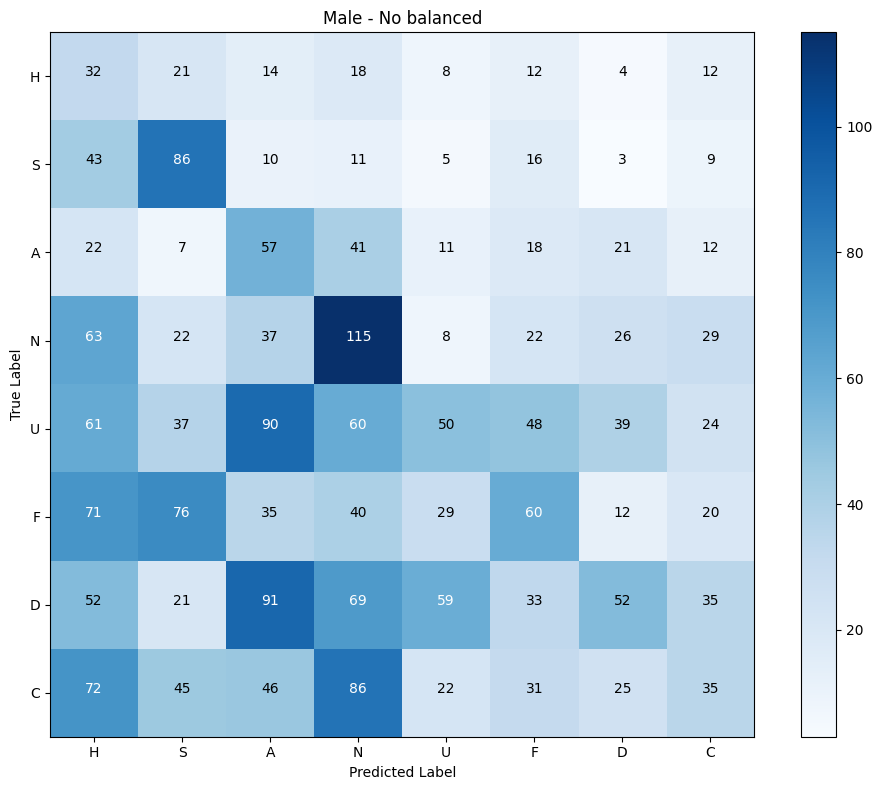

In [20]:
import matplotlib.pyplot as plt
import numpy as np

labels = label2id.keys()
conf_matrix = preds_metrics['test_confusion_matrix']


# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Male - No balanced")
plt.colorbar()

# Agregar etiquetas
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Rótulos de valores dentro de cada celda
conf_matrix = np.array(conf_matrix)

# Calcular el umbral
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(
        j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black"
    )

# Etiquetas de los ejes
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()